In [1]:
import tensorflow as tf
from tf_agents.agents import ddpg
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
import wandb

import sys
sys.path.insert(0, '..')
import utils.dataloader as dataloader
import environments.battery as battery_env
import environments.household as household_env

In [2]:
"""
Train and evaluate a DDPG agent
"""

# Param for iteration
num_iterations = 2000
customer = 1
# 0 = battery, 1 = household
# Params for collect
initial_collect_steps = 1000
collect_steps_per_iteration = 2000
replay_buffer_capacity = 1000000
ou_stddev = 0.2
ou_damping = 0.15

# Params for target update
target_update_tau = 0.05
target_update_period = 5

# Params for train
train_steps_per_iteration = 1
batch_size = 48 * 7
actor_learning_rate = 1e-4
critic_learning_rate = 1e-3
dqda_clipping = None
td_errors_loss_fn = tf.compat.v1.losses.huber_loss
gamma = 0.99
reward_scale_factor = 1.0
gradient_clipping = None

# Params for eval and checkpoints
num_eval_episodes = 1
num_test_episodes = 1
eval_interval = 50

In [3]:
# Load data
data_train = dataloader.get_customer_data(dataloader.loadData('../../data/load1011.csv'),
                                          dataloader.loadPrice('../../data/price_wo_outlier.csv'), dataloader.loadMix("../../data/fuel2021.csv"), customer)
data_eval = dataloader.get_customer_data(dataloader.loadData('../../data/load1112.csv'),
                                         dataloader.loadPrice('../../data/price_wo_outlier.csv'), dataloader.loadMix("../../data/fuel2122.csv"), customer)
data_test = dataloader.get_customer_data(dataloader.loadData('../../data/load1213.csv'),
                                         dataloader.loadPrice('../../data/price_wo_outlier.csv'), dataloader.loadMix("../../data/fuel2223.csv"), customer)


In [4]:
print("Min: ", data_train[2][:200].min()[0], " , max: ", data_train[2][:200].max()[0])

Min:  0.04114  , max:  0.20281


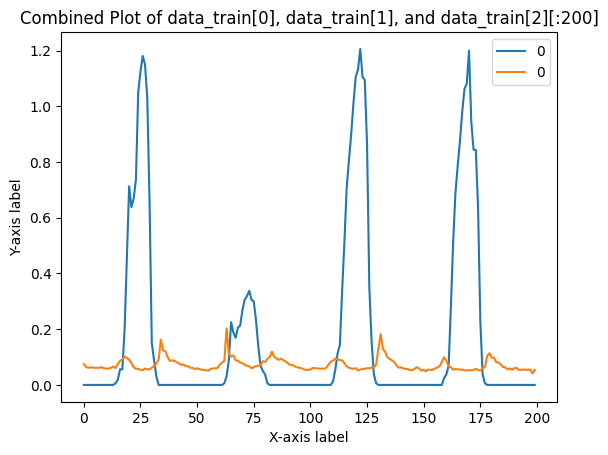

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots() 
# Assuming data_train is a list or array-like object
#data_train[0][:200].plot(label='Load', ax=ax)
data_train[1][:200].plot(label='PV', ax=ax)
data_train[2][:200].plot(label='Price', ax=ax)

# Add labels, title, and legend
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Combined Plot of data_train[0], data_train[1], and data_train[2][:200]')
plt.legend()

# Show the plot
plt.show()

In [6]:

import numpy as np
import tensorflow as tf
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
import wandb


class Battery(py_environment.PyEnvironment):

    def __init__(self, load_data, pv_data, price_data, test=False):
 
        #Time steps
        self._current_timestep = -1
        self._max_timesteps = (48 * 365)-1 #Timeslots: 2*24*365, starting at 0 -> -1

        #Battery parameters
        self._capacity = 13.5
        self._power_battery = 4.6/2
        self._init_charge = 0.0
        self._soe = 0.0
        self._power_grid = 25.0
        self._feed_in_tarif = 0.076
        self._total_electricity_bill = 0.0
        self._efficiency = 0.95

        #Observation and Action space
        self._action_spec = array_spec.BoundedArraySpec(shape=(1,), dtype=np.float32, minimum=-self._power_battery, maximum=self._power_battery, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(4,), dtype=np.float32, name='observation')

        #Data
        self._load_data = load_data
        self._pv_data = pv_data
        self._electricity_prices = price_data

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._current_timestep = -1 #is set to -1, indicating that the next timeslot will be the first one.
        self._soe = self._init_charge #is set to the initial charge value (_init_charge).
        self._total_electricity_bill = 0.0 #as it accumulates the electricity cost during each episode.
        observation = np.array([self._soe, self._load_data.iloc[0,0], self._pv_data.iloc[0,0], self._electricity_prices.iloc[0,0]], dtype=np.float32)

        return ts.restart(observation)


    def _step(self, action):

        #Update timeslot
        self._current_timestep += 1
                
        #Load data: power of load, pv, load + price
        electricity_price = self._electricity_prices.iloc[self._current_timestep, 0]
        p_load = self._load_data.iloc[self._current_timestep, 0] 
        p_pv = self._pv_data.iloc[self._current_timestep, 0] 
        p_battery = np.clip(action[0], -self._power_battery, self._power_battery, dtype=np.float32) #action within power limits
        
        #Balance battery
        old_soe = self._soe
        self._soe = np.clip(old_soe + p_battery, 0.0, self._capacity, dtype=np.float32)
        delta_soe =  self._soe - old_soe

        #Penalties
        penalty_factor_imbalance, penalty_factor_aging = 100, 100
        imbalance_penalty  = np.abs(p_battery - delta_soe)*penalty_factor_imbalance # Stay within battery capacity
        optimal_soe_range = (0.2 * self._capacity, 0.8 * self._capacity)  # Example range
        battery_aging_penalty = penalty_factor_aging if not optimal_soe_range[0] <= self._soe <= optimal_soe_range[1] else 0


        #Balance microgrid
        p_grid = p_load - p_pv + delta_soe # Positive -> buy, negative -> sell

        #Electricity bill calculations
        electricity_bill = p_grid * (-electricity_price if p_grid > 0 else -0.76)
        self._total_electricity_bill += electricity_bill
        
        reward = electricity_bill - imbalance_penalty - battery_aging_penalty
        
        #Create observation
        observation = np.array([self._soe, p_load, p_pv, electricity_price], dtype=np.float32)
        
        #Logging
        wandb.log({
            'Action [2.3, -2.3]': action[0], 
            'SoE [0, 13.5]': self._soe, 
            'Imbalance': imbalance_penalty ,
            'Episode Bill (+ profit, - cost)': electricity_bill,
            'Total Bill': self._total_electricity_bill,
            })
        # Check for episode end
        if self._current_timestep >= self._max_timesteps: 
            wandb.log({'profit': self._total_electricity_bill})
            self._reset()
            return ts.termination(observation=observation,reward=reward)          
        else:
            return ts.transition(observation=observation,reward=reward)

In [7]:
# Initiate env
tf_env_train = tf_py_environment.TFPyEnvironment(Battery(load_data=data_train[0], pv_data=data_train[1], price_data=data_train[2], test=True))
tf_env_eval = tf_py_environment.TFPyEnvironment(Battery(load_data=data_eval[0], pv_data=data_eval[1], price_data=data_eval[2], test=True))
tf_env_test = tf_py_environment.TFPyEnvironment(Battery(load_data=data_test[0], pv_data=data_test[1], price_data=data_test[2], test=True))


num_states = tf_env_train.observation_spec().shape[0]
print("Size of State Space ->  {}".format(num_states)) #SoE, price, price forecast 1-6
num_actions = tf_env_train.action_spec().shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = tf_env_train.action_spec().maximum.item()
lower_bound = tf_env_train.action_spec().minimum.item()

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  4
Size of Action Space ->  1
Max Value of Action ->  2.299999952316284
Min Value of Action ->  -2.299999952316284


In [19]:
import utils.actorNetworkCustom as actornet
import utils.actorNetworkCustom as criticnet
import utils.modelgenerator as MG

m1 = MG.ModelGenerator()
# get_dense_layers(), get_bilstm_model(), get_lstm_model(), get_cnn_lstm_model(), get_cnn_model()
custom_layers = m1.get_lstm_model()

# Create a copy of the layers, so no weights are duplicated
def copy_layer(layer):
    return tf.keras.layers.deserialize({'class_name': layer.__class__.__name__, 'config': layer.get_config()})

# Create copies of the original layers
actor_layers = [copy_layer(layer) for layer in custom_layers]
target_actor_layers = [copy_layer(layer) for layer in custom_layers]
critic_layers = [copy_layer(layer) for layer in custom_layers]
target_critic_layers = [copy_layer(layer) for layer in custom_layers]

In [20]:
# Prepare runner
global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = actornet.ActorNetworkCustom(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[actor_layers],
    )

critic_net = ddpg.critic_network.CriticNetwork(
    input_tensor_spec=(tf_env_train.observation_spec(), tf_env_train.action_spec()),
    joint_fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

tf_agent = ddpg_agent.DdpgAgent(
    tf_env_train.time_step_spec(),
    tf_env_train.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate
    ),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate
    ),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step,
)

tf_agent.initialize()

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [21]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=tf_env_train.batch_size,
    max_length=replay_buffer_capacity,
)

initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps,
)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration,
)

In [22]:
wandb.login()
wandb.init(
    project="DDPG_battery_testing",
    job_type="train_eval_test",
    name="3_ex_09",
    config={
        "train_steps": num_iterations,
        "batch_size": batch_size,
        "actor_learning_rate": actor_learning_rate,
        "critic_learning_rate": critic_learning_rate}
)

artifact = wandb.Artifact(name='save', type="checkpoint")

eval_metrics = [
    tf_metrics.AverageReturnMetric(name="AverageReturnEvaluation", buffer_size=num_eval_episodes)
]

test_metrics = [
    tf_metrics.AverageReturnMetric(name="AverageReturnTest", buffer_size=num_eval_episodes)
]

"""train_checkpointer = common.Checkpointer(
    ckpt_dir='checkpoints/ddpg/',
    max_to_keep=1,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

train_checkpointer.initialize_or_restore()"""

global_step = tf.compat.v1.train.get_global_step()

# For better performance
initial_collect_driver.run = common.function(initial_collect_driver.run)
collect_driver.run = common.function(collect_driver.run)
tf_agent.train = common.function(tf_agent.train)

# Collect initial replay data
initial_collect_driver.run()

time_step = tf_env_train.reset()
policy_state = collect_policy.get_initial_state(tf_env_train.batch_size)

# Dataset generates trajectories with shape [Bx2x...]
# pipeline which will feed data to the agent
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2
).prefetch(3)
iterator = iter(dataset)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jonas-sievers (ipe). Use `wandb login --relogin` to force relogin


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [23]:
# Train and evaluate
print("Start training ...")
while global_step.numpy() < num_iterations:
    print(global_step.numpy(), "/ ", num_iterations)
    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state,
    )
    experience, _ = next(iterator)
    train_loss = tf_agent.train(experience)
    metrics = {}
    if global_step.numpy() % eval_interval == 0:
        #train_checkpointer.save(global_step)
        metrics = metric_utils.eager_compute(
            eval_metrics,
            tf_env_eval,
            eval_policy,
            num_episodes=num_eval_episodes,
            train_step=global_step,
            summary_writer=None,
            summary_prefix='',
            use_function=True)
    
    metrics["loss"] = train_loss.loss
    wandb.log(metrics)

"""print("Start testing ...")
metrics = metric_utils.eager_compute(
    test_metrics,
    tf_env_test,
    eval_policy,
    num_episodes=num_test_episodes,
    train_step=None,
    summary_writer=None,
    summary_prefix='',
    use_function=True)
wandb.log(metrics)
#artifact.add_dir(local_path='checkpoints/ddpg/')
wandb.log_artifact(artifact)
wandb.finish()"""

Start training ...
0 /  2000
1 /  2000
2 /  2000
3 /  2000
4 /  2000
5 /  2000
6 /  2000
7 /  2000
8 /  2000
9 /  2000
10 /  2000
11 /  2000
12 /  2000
13 /  2000
14 /  2000
15 /  2000
16 /  2000
17 /  2000
18 /  2000
19 /  2000
20 /  2000
21 /  2000
22 /  2000
23 /  2000
24 /  2000
25 /  2000
26 /  2000
27 /  2000
28 /  2000
29 /  2000
30 /  2000
31 /  2000
32 /  2000
33 /  2000
34 /  2000
35 /  2000
36 /  2000
37 /  2000
38 /  2000
39 /  2000
40 /  2000
41 /  2000
42 /  2000
43 /  2000
44 /  2000
45 /  2000
46 /  2000
47 /  2000
48 /  2000
49 /  2000
50 /  2000
51 /  2000
52 /  2000
53 /  2000
54 /  2000
55 /  2000
56 /  2000
57 /  2000
58 /  2000
59 /  2000
60 /  2000
61 /  2000
62 /  2000
63 /  2000
64 /  2000
65 /  2000
66 /  2000
67 /  2000
68 /  2000
69 /  2000
70 /  2000
71 /  2000
72 /  2000
73 /  2000
74 /  2000
75 /  2000
76 /  2000
77 /  2000
78 /  2000
79 /  2000
80 /  2000
81 /  2000
82 /  2000
83 /  2000
84 /  2000
85 /  2000
86 /  2000
87 /  2000
88 /  2000
89 /  2000
9

KeyboardInterrupt: 